In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np

# Check for GPU availability (but don't use it)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# 1. Data Loading and Preprocessing

try:
    data = pd.read_csv("../data/zomato.csv", encoding='utf-8') 
except UnicodeDecodeError:
    try:
        data = pd.read_csv("../data/zomato.csv", encoding='latin-1') 
    except UnicodeDecodeError:
        try:
            data = pd.read_csv("../data/zomato.csv", encoding='cp1252') 
        except UnicodeDecodeError:
            raise UnicodeDecodeError("Failed to decode zomato.csv with common encodings")

# Select relevant features
features = ['City', 'Cuisines', 'Average Cost for two', 'Price range', 'Aggregate rating']
target = 'Votes'

# Handle missing values
numerical_features = ['Average Cost for two', 'Price range', 'Aggregate rating']
imputer_num = SimpleImputer(strategy='mean')  # Imputer for numerical features
data[numerical_features] = imputer_num.fit_transform(data[numerical_features])

# Handle missing values in categorical features (e.g., 'City')
categorical_features = ['City']
imputer_cat = SimpleImputer(strategy='most_frequent')
for col in categorical_features:
    data[col] = imputer_cat.fit_transform(data[[col]])[:, 0] 

# Handle non-string values in 'Cuisines' (e.g., replace with empty string)
data['Cuisines'] = data['Cuisines'].fillna('').astype(str) 

# Handle categorical features
city_encoder = OneHotEncoder(handle_unknown='ignore') 
city_encoded = city_encoder.fit_transform(data[['City']])
city_df = pd.DataFrame(city_encoded.toarray(), columns=city_encoder.get_feature_names_out(['City'])) 

cuisines_list = []
for cuisines in data['Cuisines']:
    for cuisine in cuisines.split(','):
        cuisines_list.append([cuisine.strip()])  # Create a list of lists for each cuisine

cuisines_encoder = OneHotEncoder(handle_unknown='ignore')
cuisines_encoded = cuisines_encoder.fit_transform(np.array(cuisines_list))

# Check for number of unique cuisines
n_unique_cuisines = len(set(cuisines_encoder.get_feature_names_out(['Cuisines'])))

# Handle single cuisine case
if n_unique_cuisines == 1:
    # Option 1: Drop the Cuisine Column
    cuisines_df = pd.DataFrame() 
    # Option 2: Keep the Cuisine Column (Optional)
    # cuisines_encoded = cuisines_encoded.reshape(1, -1) 
    # cuisines_df = pd.DataFrame(cuisines_encoded, columns=cuisines_encoder.get_feature_names_out(['Cuisines'])) 

# Combine encoded features with numerical features
X = pd.concat([data[['Average Cost for two', 'Price range', 'Aggregate rating']], city_df], axis=1)  # Concatenate without cuisines_df if dropped

y = data[target]

# Scale numerical features
scaler = StandardScaler()
X[['Average Cost for two', 'Price range', 'Aggregate rating']] = scaler.fit_transform(X[['Average Cost for two', 'Price range', 'Aggregate rating']])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Model Training

# Create the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# 3. Model Evaluation

# Make predictions
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = np.mean((y_pred.flatten() - y_test)**2)  # Flatten y_pred 
print(f"Mean Squared Error: {mse}")

# 4. Model Saving
model.save("zomato_demand_model.h5")

Available GPUs: []
Epoch 1/100


C:\Users\sampa\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 183280.4375 - val_loss: 218939.1406
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157111.1094 - val_loss: 181009.8906
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113572.8047 - val_loss: 173924.8125
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138602.9062 - val_loss: 169711.8281
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122462.3516 - val_loss: 165899.6094
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123254.7734 - val_loss: 162719.7969
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129977.1953 - val_loss: 159905.2812
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122832.3281 - val_loss: 156938.9375
Epoch 9/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139411.7969 - val_loss: 154111.7656
Epoch 10/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123685.9531 - val_loss: 152173.5938
Epoch 11/100
191/191 ━━━━━━━━━━━━━━━━━━━━

Mean Squared Error: 119104.1509094723


In [22]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

R-squared: 0.3984917402267456


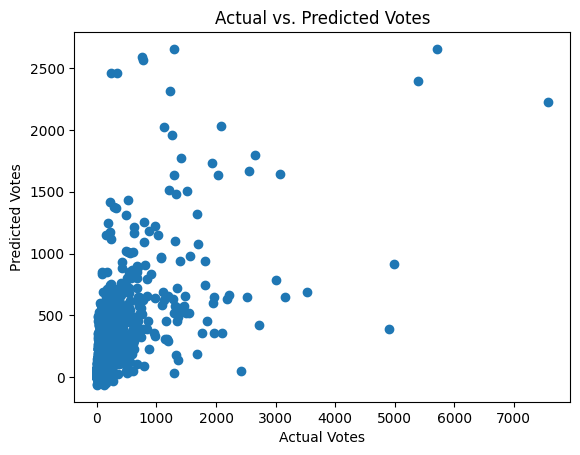

In [23]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Votes")
plt.ylabel("Predicted Votes")
plt.title("Actual vs. Predicted Votes")
plt.show()

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np

# Check for GPU availability (but don't use it)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# 1. Data Loading and Preprocessing

try:
    data = pd.read_csv("../data/zomato.csv", encoding='utf-8') 
except UnicodeDecodeError:
    try:
        data = pd.read_csv("../data/zomato.csv", encoding='latin-1') 
    except UnicodeDecodeError:
        try:
            data = pd.read_csv("../data/zomato.csv", encoding='cp1252') 
        except UnicodeDecodeError:
            raise UnicodeDecodeError("Failed to decode zomato.csv with common encodings")

# Select relevant features
features = ['City', 'Cuisines', 'Average Cost for two', 'Price range', 'Aggregate rating']
target = 'Votes'

# Handle missing values
numerical_features = ['Average Cost for two', 'Price range', 'Aggregate rating']
imputer_num = SimpleImputer(strategy='mean')  # Imputer for numerical features
data[numerical_features] = imputer_num.fit_transform(data[numerical_features])

# Handle missing values in categorical features (e.g., 'City')
categorical_features = ['City']
imputer_cat = SimpleImputer(strategy='most_frequent')
for col in categorical_features:
    data[col] = imputer_cat.fit_transform(data[[col]])[:, 0] 

# Handle non-string values in 'Cuisines' (e.g., replace with empty string)
data['Cuisines'] = data['Cuisines'].fillna('').astype(str) 

# Handle categorical features
city_encoder = OneHotEncoder(handle_unknown='ignore') 
city_encoded = city_encoder.fit_transform(data[['City']])
city_df = pd.DataFrame(city_encoded.toarray(), columns=city_encoder.get_feature_names_out(['City'])) 

cuisines_list = []
for cuisines in data['Cuisines']:
    for cuisine in cuisines.split(','):
        cuisines_list.append([cuisine.strip()])  # Create a list of lists for each cuisine

cuisines_encoder = OneHotEncoder(handle_unknown='ignore')
cuisines_encoded = cuisines_encoder.fit_transform(np.array(cuisines_list))

# Check for number of unique cuisines
n_unique_cuisines = len(set(cuisines_encoder.get_feature_names_out(['Cuisines'])))

# Handle single cuisine case
if n_unique_cuisines == 1:
    # Option 1: Drop the Cuisine Column
    cuisines_df = pd.DataFrame() 
    # Option 2: Keep the Cuisine Column (Optional)
    # cuisines_encoded = cuisines_encoded.reshape(1, -1) 
    # cuisines_df = pd.DataFrame(cuisines_encoded, columns=cuisines_encoder.get_feature_names_out(['Cuisines'])) 

# Combine encoded features with numerical features
X = pd.concat([data[['Average Cost for two', 'Price range', 'Aggregate rating']], city_df], axis=1)  # Concatenate without cuisines_df if dropped

y = data[target]

# Scale numerical features
scaler = StandardScaler()
X[['Average Cost for two', 'Price range', 'Aggregate rating']] = scaler.fit_transform(X[['Average Cost for two', 'Price range', 'Aggregate rating']])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Model Training

# Define a function to create the model
def create_model(units1=64, units2=32):
    model = Sequential()
    model.add(Dense(units1, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units2, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define the hyperparameter grid
param_grid = {'units1': [32, 64, 128], 'units2': [16, 32, 64]}

# Perform manual hyperparameter tuning
best_score = float('inf')
best_params = None

for units1 in param_grid['units1']:
    for units2 in param_grid['units2']:
        # Create and train the model with current hyperparameters
        model = create_model(units1, units2)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0) 

        # Extract the best validation loss 
        if hasattr(early_stopping, 'best_val_loss'): 
            validation_mse = early_stopping.best_val_loss
        else:
            validation_mse = min(history.history['val_loss'])

        if validation_mse < best_score:
            best_score = validation_mse
            best_params = {'units1': units1, 'units2': units2}

print("Best Hyperparameters:", best_params)
print("Best Validation Score (MSE):", best_score)

# Create and train the final model with the best hyperparameters
best_model = create_model(units1=best_params['units1'], units2=best_params['units2'])
best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error
mse = np.mean((y_pred.flatten() - y_test)**2)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# 4. Model Saving
best_model.save("zomato_demand_model.h5")

Available GPUs: []


C:\Users\sampa\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sampa\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sampa\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

Best Hyperparameters: {'units1': 64, 'units2': 64}
Best Validation Score (MSE): 125467.046875
Epoch 1/100


C:\Users\sampa\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 202702.9688 - val_loss: 198495.4062
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122764.9297 - val_loss: 175180.2031
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144769.4375 - val_loss: 169711.6094
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126213.8203 - val_loss: 165199.5156
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128226.0781 - val_loss: 161310.7812
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128341.7891 - val_loss: 157221.7031
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 125682.7969 - val_loss: 153915.8906
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109174.2422 - val_loss: 150215.3750
Epoch 9/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96391.3750 - val_loss: 147389.7500
Epoch 10/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95739.9453 - val_loss: 145071.3750
Epoch 11/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0

Mean Squared Error: 118538.16896098694
Root Mean Squared Error (RMSE): 344.2937248353315
R-squared: 0.401350200176239


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

# Check for GPU availability (but don't use it)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# 1. Data Loading and Preprocessing

try:
    data = pd.read_csv("../data/zomato.csv", encoding='utf-8') 
except UnicodeDecodeError:
    try:
        data = pd.read_csv("../data/zomato.csv", encoding='latin-1') 
    except UnicodeDecodeError:
        try:
            data = pd.read_csv("../data/zomato.csv", encoding='cp1252') 
        except UnicodeDecodeError:
            raise UnicodeDecodeError("Failed to decode zomato.csv with common encodings")

# Select relevant features
features = ['City', 'Cuisines', 'Average Cost for two', 'Price range', 'Aggregate rating']
target = 'Votes'

# Handle missing values
numerical_features = ['Average Cost for two', 'Price range', 'Aggregate rating']
imputer_num = SimpleImputer(strategy='mean')  # Imputer for numerical features
data[numerical_features] = imputer_num.fit_transform(data[numerical_features])

# Handle missing values in categorical features (e.g., 'City')
categorical_features = ['City']
imputer_cat = SimpleImputer(strategy='most_frequent')
for col in categorical_features:
    data[col] = imputer_cat.fit_transform(data[[col]])[:, 0] 

# Handle non-string values in 'Cuisines' (e.g., replace with empty string)
data['Cuisines'] = data['Cuisines'].fillna('').astype(str) 

# Handle categorical features
city_encoder = OneHotEncoder(handle_unknown='ignore') 
city_encoded = city_encoder.fit_transform(data[['City']])
city_df = pd.DataFrame(city_encoded.toarray(), columns=city_encoder.get_feature_names_out(['City'])) 

# Feature Engineering: Cuisine Grouping
cuisine_groups = {
    'Indian': ['Indian', 'North Indian', 'South Indian'],
    'Italian': ['Italian', 'Pizza', 'Pasta'],
    'Asian': ['Chinese', 'Japanese', 'Thai', 'Korean'],
    'Mexican': ['Mexican'],
    'Others': ['Others']  # For cuisines not in defined groups
}

def categorize_cuisine(cuisine):
    for group, cuisines in cuisine_groups.items():
        if cuisine in cuisines:
            return group
    return 'Others'

data['Cuisine_Group'] = data['Cuisines'].str.split(',').apply(lambda x: categorize_cuisine(x[0])) 
cuisine_group_encoder = OneHotEncoder(handle_unknown='ignore')
cuisine_group_encoded = cuisine_group_encoder.fit_transform(data[['Cuisine_Group']])
cuisine_group_df = pd.DataFrame(cuisine_group_encoded.toarray(), 
                                columns=cuisine_group_encoder.get_feature_names_out(['Cuisine_Group']))

data['Num_Cuisines'] = data['Cuisines'].str.split(',').apply(len) 

# Combine encoded features with numerical features
X = pd.concat([data[['Average Cost for two', 'Price range', 'Aggregate rating', 'Num_Cuisines']], city_df, cuisine_group_df], axis=1) 

y = data[target]

# Scale numerical features
scaler = StandardScaler()
X[['Average Cost for two', 'Price range', 'Aggregate rating']] = scaler.fit_transform(X[['Average Cost for two', 'Price range', 'Aggregate rating']])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Model Training

# Define a function to create the model
def create_model(units1=64, units2=32, units3=16):
    model = Sequential()
    model.add(Dense(units1, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units2, activation='relu'))
    model.add(Dense(units3, activation='relu'))
    model.add(Dense(1)) 
    return model

# Define the hyperparameter grid
param_grid = {
    'units1': [32, 64, 128, 256], 
    'units2': [16, 32, 64, 128], 
    'units3': [8, 16, 32]
}

# Perform manual hyperparameter tuning
best_score = float('inf')
best_params = None

for units1 in param_grid['units1']:
    for units2 in param_grid['units2']:
        for units3 in param_grid['units3']:
            # Create and train the model with current hyperparameters
            model = create_model(units1, units2, units3)
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
            # Learning Rate Schedule
            def scheduler(epoch, lr):
                if epoch < 10:
                    return lr
                else:
                    return lr * 0.9  # Reduce learning rate by 10% after 10 epochs
            lr_scheduler = LearningRateScheduler(scheduler)
            
            optimizer = Adam(learning_rate=0.001) 
            model.compile(loss='mean_squared_error', optimizer=optimizer) 
            history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, 
                                callbacks=[early_stopping, lr_scheduler], verbose=0) 

            # Extract the best validation loss 
            if hasattr(early_stopping, 'best_val_loss'): 
                validation_mse = early_stopping.best_val_loss
            else:
                validation_mse = min(history.history['val_loss'])

            if validation_mse < best_score:
                best_score = validation_mse
                best_params = {'units1': units1, 'units2': units2, 'units3': units3}

print("Best Hyperparameters:", best_params)
print("Best Validation Score (MSE):", best_score)

# Create and train the final model with the best hyperparameters
best_model = create_model(units1=best_params['units1'], 
                         units2=best_params['units2'], 
                         units3=best_params['units3'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
optimizer = Adam(learning_rate=0.001) 
best_model.compile(loss='mean_squared_error', optimizer=optimizer)
best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error
mse = np.mean((y_pred.flatten() - y_test)**2)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# 4. Model Saving
best_model.save("zomato_demand_model.keras")

KeyboardInterrupt: 

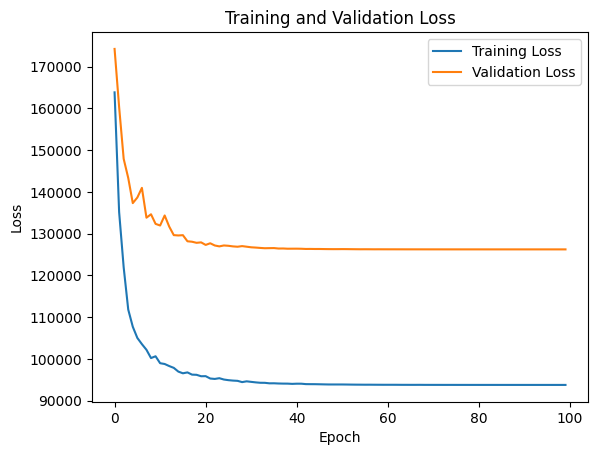

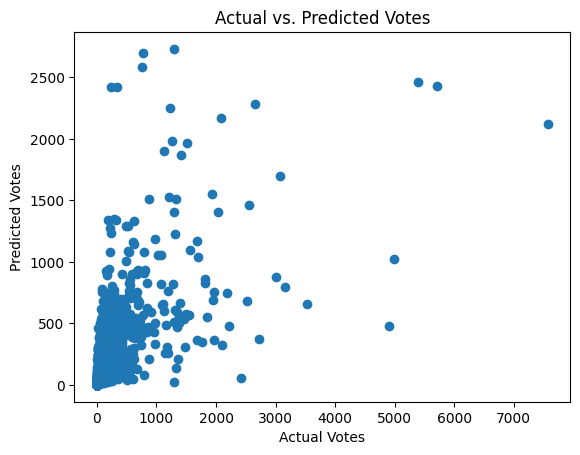

ValueError: Data must be 1-dimensional, got ndarray of shape (1911, 1911) instead

In [40]:
# ... (previous code for model training and evaluation) ...

# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Votes')
plt.ylabel('Predicted Votes')
plt.title('Actual vs. Predicted Votes')
plt.show()

# ... (previous code for model training and evaluation) ...
# ... (previous code for model training and evaluation) ...

# Assuming y_test and y_pred are 1D arrays (e.g., extracted from DataFrames)
prediction_errors = y_test - y_pred 

# Plot the distribution of errors (1D array)
plt.hist(prediction_errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

# Residual Plot
plt.scatter(y_pred, prediction_errors)
plt.xlabel('Predicted Votes')
plt.ylabel('Prediction Error')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.show()

In [41]:
# Save the model
best_model.save("zomato_demand_model.keras")

In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd

# Load the trained model
loaded_model = load_model("zomato_demand_model.keras")

# Sample data for prediction (replace with your desired values)
# Assuming you know the original number of features (150 in this case)
sample_data = {
    'Average Cost for two': [1500],  # Replace with your desired value
    'Price range': [2],            # Replace with your desired value
    'Aggregate rating': [4.5],      # Replace with your desired value
    # ... Include placeholder values (e.g., zeros) for potentially missing features ...
    'City_New Delhi': [1],  # Assuming this city was present in the training data
    'City_Gurgaon': [0],   # ... and so on for other cities and cuisine groups
    'City_Noida': [0],    # ... include placeholders for all expected cities
    'City_Faridabad': [0],
    'City_Ghaziabad': [0],
    'Cuisine_Group_Indian': [1],  # Assuming this cuisine group was present
    'Cuisine_Group_Italian': [0],  # ... and so on for other cuisine groups
    'Cuisine_Group_Asian': [0],   # ... include placeholders for all cuisine groups
    'Cuisine_Group_Mexican': [0],
    'Cuisine_Group_Others': [0],
    # ... include placeholders for any other features the model expects ...
    'Num_Cuisines': [2]  # Replace with the actual number of cuisines
}

# Create a DataFrame from the sample_data
sample_df = pd.DataFrame(sample_data)

try:
  # Make a prediction
  predicted_votes = loaded_model.predict(sample_df)
  print(f"Predicted Votes: {predicted_votes[0][0]}")
except ValueError

Error: Exception encountered when calling Sequential.call().

Input 0 of layer "dense_342" is incompatible with the layer: expected axis -1 of input shape to have value 150, but received input with shape (1, 14)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 14), dtype=float32)
  • training=False
  • mask=None
**Possible Causes:**
- Missing features in sample_data (include placeholders for all expected features)
- Incorrect feature order (ensure order matches the training data)
- Extra features in sample_data (remove if not present in the model)
- Check model architecture for expected input shape (if possible)
- Review training data features for one-hot encoding (if possible)


17:30:21 - cmdstanpy - INFO - Chain [1] start processing
17:32:39 - cmdstanpy - INFO - Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
1801 2024-12-06  268.606195 -259.041705  775.933514
1802 2024-12-07  268.197301 -257.333647  764.321418
1803 2024-12-08  266.841644 -245.242358  745.998431
1804 2024-12-09  267.416718 -254.124536  764.035196
1805 2024-12-10  267.297160 -272.401684  776.631775


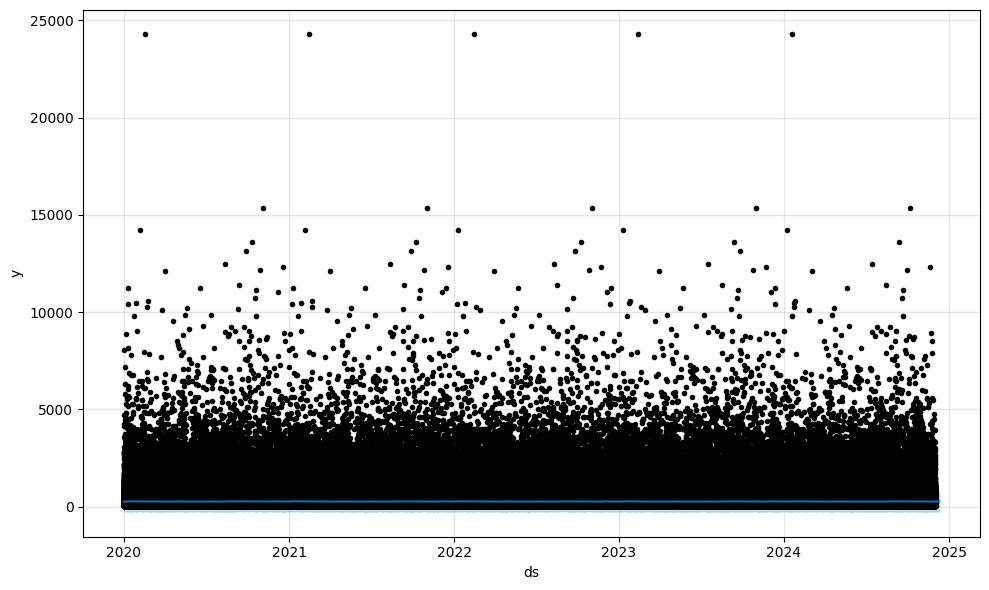

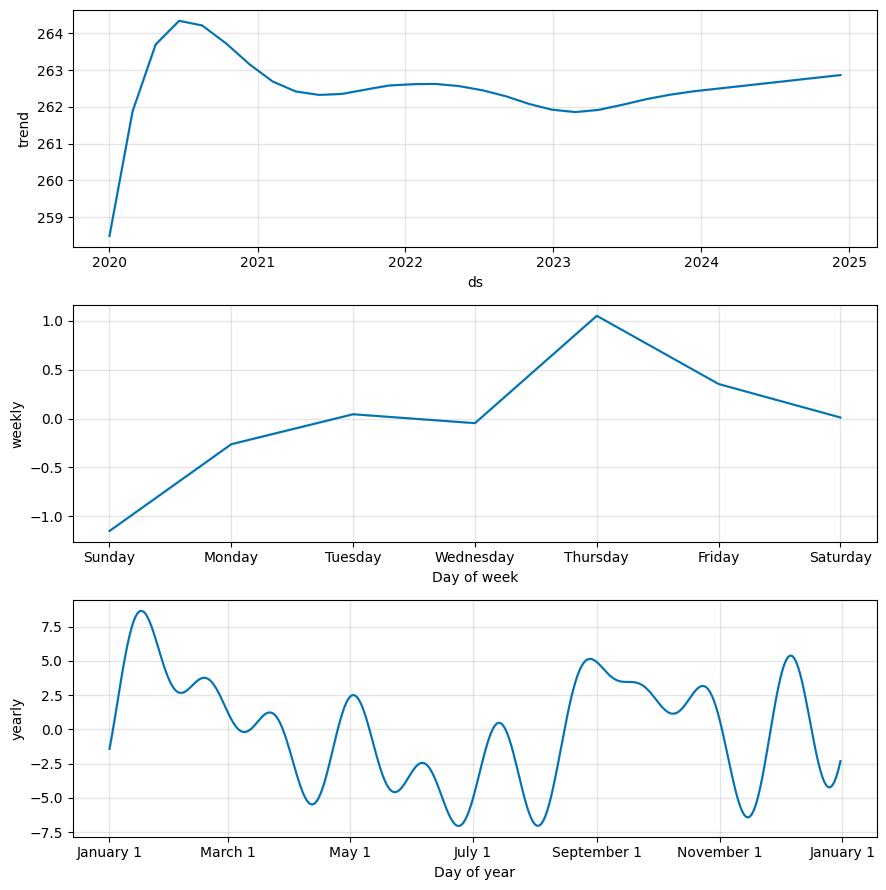

In [ ]:
import pandas as pd
from prophet import Prophet
from datetime import datetime, timedelta

# Load data
data = pd.read_csv('../data/train_replicated_with_dates.csv')

# Convert 'date' to datetime and rename it to 'ds' for Prophet
data['ds'] = pd.to_datetime(data['date'], errors='coerce')
data['y'] = data['num_orders']

# Remove any rows where 'ds' couldn't be converted (which would result in NaT)
data = data.dropna(subset=['ds'])

# Check for out of bounds dates
out_of_bounds = data['ds'] > pd.Timestamp('2262-04-11')
if out_of_bounds.any():
    print("Number of out of bounds dates:", out_of_bounds.sum())
    print("Sample of out of bounds dates:", data['ds'][out_of_bounds].head())
    # If you have out of bounds dates, you might want to filter them out or handle them differently
    data = data[~out_of_bounds]

# Now you can proceed with Prophet
m = Prophet()

# Fit the model
m.fit(data)

# Make future dataframe for predictions. Here, we'll predict for the next 10 days
future = m.make_future_dataframe(periods=10)

# Predict
forecast = m.predict(future)

# View the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [57]:
from tensorflow.keras.models import load_model

loaded_model = load_model("zomato_demand_model.keras")
print("Model expects input shape:", loaded_model.input_shape)

Model expects input shape: (None, 150)


In [58]:
# Assuming you've identified all 150 features from training data
all_features = list(X.columns)  # Replace with actual feature names

# Create sample data with all features
sample_data = {feature: [0] for feature in all_features}  # Start with zeros for all

# Then modify relevant features
sample_data['Average Cost for two'] = [1500]
sample_data['Price range'] = [2]
sample_data['Aggregate rating'] = [4.5]
sample_data['City_New Delhi'] = [1]  # Example, adjust based on your data
sample_data['Cuisine_Group_Indian'] = [1]  # Example, adjust based on your data
sample_data['Num_Cuisines'] = [2]  # Example

# Create the DataFrame
sample_df = pd.DataFrame(sample_data)

In [59]:
try:
    predicted_votes = loaded_model.predict(sample_df)
    print(f"Predicted Votes: {predicted_votes[0][0]}")
except ValueError as e:
    print("Error:", e)
    print("Please review feature names, order, and ensure all expected features are included.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Predicted Votes: 39025.75390625


In [61]:
# Multiple prediction examples
sample_data_multiple = [
    {'Average Cost for two': 1500, 'Price range': 2, 'Aggregate rating': 4.5, 'City_New Delhi': 1, 'Cuisine_Group_Indian': 1, 'Num_Cuisines': 2},
    {'Average Cost for two': 800, 'Price range': 1, 'Aggregate rating': 3.0, 'City_Mumbai': 1, 'Cuisine_Group_Italian': 1, 'Num_Cuisines': 1},
    # Add more examples as needed
]

multiple_samples = pd.DataFrame(sample_data_multiple)

# Ensure all features are included (fill with zeros for simplicity)
for feature in all_features:
    if feature not in multiple_samples.columns:
        multiple_samples[feature] = 0

predictions = loaded_model.predict(multiple_samples)

for i, pred in enumerate(predictions):
    print(f"Predicted Votes for Example {i+1}: {pred[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Votes for Example 1: 5.119985580444336
Predicted Votes for Example 2: 5.119985580444336


C:\Users\sampa\AppData\Local\Temp\ipykernel_8100\3119710726.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  multiple_samples[feature] = 0
C:\Users\sampa\AppData\Local\Temp\ipykernel_8100\3119710726.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  multiple_samples[feature] = 0
C:\Users\sampa\AppData\Local\Temp\ipykernel_8100\3119710726.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

In [62]:
# Instead of this:
for feature in all_features:
    if feature not in multiple_samples.columns:
        multiple_samples[feature] = 0

# Use this:
missing_features = set(all_features) - set(multiple_samples.columns)
for feature in missing_features:
    multiple_samples[feature] = 0

# Or even better for performance:
import numpy as np
missing_features = list(set(all_features) - set(multiple_samples.columns))
new_cols = pd.DataFrame(np.zeros((len(multiple_samples), len(missing_features))), columns=missing_features)
multiple_samples = pd.concat([multiple_samples, new_cols], axis=1)